### <span style='color:#ff5f27'> 📝 Imports

In [2]:
import pandas as pd

from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import f1_score

import warnings
warnings.filterwarnings("ignore")

---

## <span style="color:#ff5f27;"> 📡 Connecting to Hopsworks Feature Store </span>

In [3]:
import hopsworks

project = hopsworks.login() 

fs = project.get_feature_store() 

Connected. Call `.close()` to terminate connection gracefully.

Multiple projects found. 

	 (1) ID2223_Anton
	 (2) ID2223_Ernest

Enter project to access: 2

Logged in to project, explore it here https://c.app.hopsworks.ai:443/p/5476
Connected. Call `.close()` to terminate connection gracefully.


---

## <span style="color:#ff5f27;">🪝 Feature View and Training Dataset Retrieval</span>

In [14]:
feature_view = fs.get_feature_view(
    name = 'poland_air_quality_fv',
    version = 1
)

In [16]:
train_data = feature_view.get_training_data(1)[0]

train_data.head()

,date,pm10,city,tempmax,tempmin,temp,feelslikemax,feelslikemin,feelslike,dew,...,winddir,cloudcover,visibility,solarradiation,solarenergy,uvindex,conditions,area,density,no_people
0,1668553200000,9.0,1,-0.569754,-0.446147,-0.352197,-0.380400,-0.577207,-0.238770,0.173884,...,-1.620929,1.314187,-1.762545,-1.219944,-1.235168,-1.525506,4,-0.139809,0.315842,-0.196725
1,1656021600000,21.0,0,1.479146,1.291086,1.545315,1.416654,1.309033,1.476897,1.387416,...,-0.786056,-1.994214,0.654587,1.823098,1.833709,1.354538,6,0.857549,0.599018,0.748324
2,1649628000000,27.0,2,-0.592520,-0.876743,-0.773866,-0.629990,-0.735408,-0.659386,-0.805714,...,0.680553,-0.694485,-0.505203,1.272968,1.282563,0.994532,1,-1.303124,-1.322860,-1.288738
3,1644015600000,5.0,0,-0.831558,-0.520387,-0.694803,-1.009368,-0.820593,-0.925037,-0.498676,...,0.498689,0.833681,-0.169189,-0.984948,-0.984647,-1.165500,5,0.857549,0.599018,0.748324
4,1646607600000,36.0,3,-0.592520,-1.129161,-0.971524,-0.699876,-1.185672,-0.991450,-1.185857,...,1.277194,-0.273058,-0.049958,-0.065537,-0.095299,0.274522,1,0.842104,1.116001,1.037148


---

## <span style="color:#ff5f27;">🧬 Modeling</span>

In [45]:
mr = project.get_model_registry()

Connected. Call `.close()` to terminate connection gracefully.


In [48]:
X = train_data.drop(columns=["date", "city"]).dropna()
y = X.pop("pm10")

MAE: 3.99
   pm10_real  pm10_pred
0       36.0         26
1       15.0         15
2       28.0         27
3       47.0         31
4       19.0         21
5       21.0         21


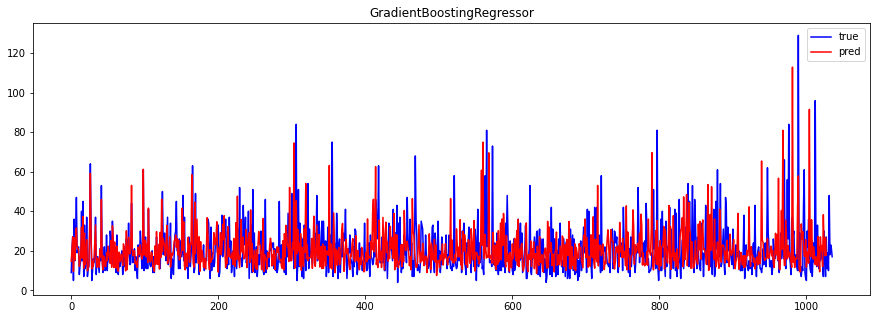

  0%|          | 0/6 [00:00<?, ?it/s]

Model created, explore it at https://c.app.hopsworks.ai:443/p/5476/models/RandomForestRegressor/4
MAE: 2.18
   pm10_real  pm10_pred
0       36.0         31
1       15.0         15
2       28.0         30
3       47.0         41
4       19.0         21
5       21.0         20


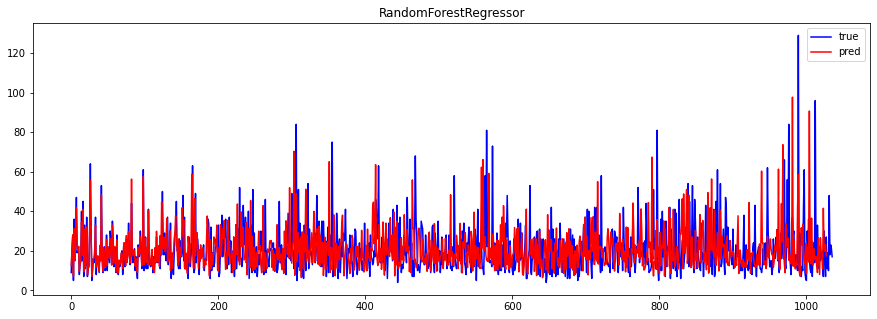

  0%|          | 0/6 [00:00<?, ?it/s]

Model created, explore it at https://c.app.hopsworks.ai:443/p/5476/models/RandomForestRegressor/5
MAE: 6.39
   pm10_real  pm10_pred
0       36.0         25
1       15.0         17
2       28.0         30
3       47.0         31
4       19.0         18
5       21.0         22


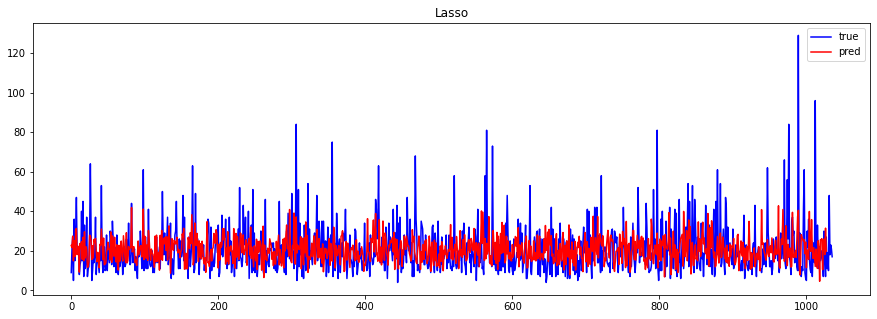

  0%|          | 0/6 [00:00<?, ?it/s]

Model created, explore it at https://c.app.hopsworks.ai:443/p/5476/models/RandomForestRegressor/6


In [49]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import Lasso
from sklearn.metrics import mean_absolute_error
from matplotlib import pyplot as plt
from hsml.schema import Schema
from hsml.model_schema import ModelSchema



model_names = ["GradientBoostingRegressor", "RandomForestRegressor", "Lasso"]

gb = GradientBoostingRegressor()
rfr = RandomForestRegressor()
lasso = Lasso()
models = [gb, rfr, lasso]
models_trained = {m: None for m in model_names}

for i, model in enumerate(models):
    model.fit(X, y)
    mae = mean_absolute_error(y, model.predict(X))
    print("MAE: {:.2f}".format(mae))
    
    pred_df = pd.DataFrame({
    'pm10_real': y.iloc[4:10].values,
    'pm10_pred': map(int, model.predict(X.iloc[4:10]))
    }
    )
    print(pred_df)
    fig = plt.figure(figsize=(15,5))
    plt.plot(y, label='true', c='b')
    plt.plot(model.predict(X), label='pred', c='r')
    plt.legend()
    plt.title(model_names[i])
    plt.show()
    
    models_trained[model_names[i]] = model
    
    input_schema = Schema(X)
    output_schema = Schema(y)
    model_schema = ModelSchema(input_schema=input_schema, output_schema=output_schema)
    
    joblib.dump(model, f'{model_name}.pkl')

    model = mr.sklearn.create_model(
        name=model_name,
        metrics={"mae": mae},
        description=f"{model_name} with default sklearn parameters",
        input_example=X.sample().to_numpy(),
        model_schema=model_schema
    )

    model.save(f'{model_name}.pkl')

---